In [29]:
# 1. Import required libraries

import pandas as pd
import numpy as np
import re

from hazm import Normalizer, WordTokenizer, stopwords_list

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


In [30]:
# 2. Load the cleaned dataset from the previous notebook
df = pd.read_csv('/mnt/e/genAI/4supervised_ML_workshop/samsung_mobiles.csv')

# Display basic info 
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (13658, 7)


,product_id,body,rate,title_en,rating,rating_count,sentiment
0,16736269,گوشی مطابق رنگ انتخابی ارسال . به درستی و آسان...,5.0,Samsung Galaxy S24 FE Dual SIM Storage 256GB A...,90.47,3436,positive
1,16736269,ممنون از دیجی. از خریدم راضی بودم.,3.0,Samsung Galaxy S24 FE Dual SIM Storage 256GB A...,90.47,3436,neutral
2,16736269,چقد طول میکشه تا فول شارژ بشه,0.0,Samsung Galaxy S24 FE Dual SIM Storage 256GB A...,90.47,3436,negative
3,16736269,گوشی خوبیه کیفیت صفحه بنظر من که گوشی قبلم a52...,5.0,Samsung Galaxy S24 FE Dual SIM Storage 256GB A...,90.47,3436,positive
4,16736269,گوشیه خوبی ولی کاش قیمتش کمی مناسب تر بود و ای...,5.0,Samsung Galaxy S24 FE Dual SIM Storage 256GB A...,90.47,3436,positive


In [31]:
# 3. Keep relevant columns & drop missing values

df = df[["body", "sentiment"]]

# Drop rows where body or sentiment is missing
df.dropna(subset=["body", "sentiment"], inplace=True)

print("Remaining rows after dropping NAs:", len(df))
df.head()

Remaining rows after dropping NAs: 13658


,body,sentiment
0,گوشی مطابق رنگ انتخابی ارسال . به درستی و آسان...,positive
1,ممنون از دیجی. از خریدم راضی بودم.,neutral
2,چقد طول میکشه تا فول شارژ بشه,negative
3,گوشی خوبیه کیفیت صفحه بنظر من که گوشی قبلم a52...,positive
4,گوشیه خوبی ولی کاش قیمتش کمی مناسب تر بود و ای...,positive


In [32]:
# 4. Advanced Persian text preprocessing

normalizer = Normalizer()
tokenizer = WordTokenizer()
stopwords = set(stopwords_list())

def clean_text(text):
    text = str(text)

    # Remove URLs
    text = re.sub(r"http\S+", " ", text)

    # Remove non-Persian characters
    text = re.sub(r"[^آ-ی\s]", " ", text)

    # Normalize Persian
    text = normalizer.normalize(text)

    # Tokenize
    tokens = tokenizer.tokenize(text)

    # Remove stopwords
    tokens = [t for t in tokens if t not in stopwords and len(t) > 2]

    return " ".join(tokens)


# Apply preprocessing with progress bar
tqdm.pandas(desc="Cleaning text")
df["comment"] = df["body"].progress_apply(clean_text)

df[["body", "comment"]].head()


Cleaning text: 100%|██████████| 13658/13658 [00:06<00:00, 1988.99it/s]


,body,comment
0,گوشی مطابق رنگ انتخابی ارسال . به درستی و آسان...,گوشی مطابق رنگ انتخابی ارسال درستی آسانی ریجست...
1,ممنون از دیجی. از خریدم راضی بودم.,ممنون دیجی خریدم راضی بودم
2,چقد طول میکشه تا فول شارژ بشه,چقد میکشه فول شارژ بشه
3,گوشی خوبیه کیفیت صفحه بنظر من که گوشی قبلم a52...,گوشی خوبیه کیفیت صفحه بنظر گوشی قبلم رنگ‌ها نم...
4,گوشیه خوبی ولی کاش قیمتش کمی مناسب تر بود و ای...,گوشیه کاش قیمتش مناسب‌تر و‌ای کاش شارژر داخل ج...


In [33]:
# 5. Encode sentiment labels

le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment"])

print("Label mapping:")
for cls, encoded in zip(le.classes_, le.transform(le.classes_)):
    print(f"{cls} → {encoded}")

df[["sentiment", "label"]].head()

Label mapping:
negative → 0
neutral → 1
positive → 2


,sentiment,label
0,positive,2
1,neutral,1
2,negative,0
3,positive,2
4,positive,2


In [34]:
# 6. Train-test split

X = df["comment"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))


Train size: 10926
Test size : 2732


In [35]:
# 7. Targeted oversampling for minority classes

train_df = pd.DataFrame({"text": X_train.values, "label": y_train.values})

print("Class distribution BEFORE oversampling:")
print(train_df["label"].value_counts())

# Identify positive label index
positive_label = le.transform(["positive"])[0]

counts = train_df["label"].value_counts()
pos_count = counts[positive_label]

balanced_parts = []

for label_value, group in train_df.groupby("label"):
    if label_value == positive_label:
        # Do not oversample majority positive class
        balanced_parts.append(group)
    else:
        # Oversample negative and neutral to half of positive count
        upsampled = resample(
            group,
            replace=True,
            n_samples=pos_count // 2,
            random_state=42
        )
        balanced_parts.append(upsampled)

train_balanced = pd.concat(balanced_parts, axis=0).sample(frac=1, random_state=42)

print("\nClass distribution AFTER oversampling:")
print(train_balanced["label"].value_counts())

X_train_bal = train_balanced["text"]
y_train_bal = train_balanced["label"]


Class distribution BEFORE oversampling:
label
2    8488
0    1308
1    1130
Name: count, dtype: int64

Class distribution AFTER oversampling:
label
2    8488
0    4244
1    4244
Name: count, dtype: int64


In [36]:
# 8. TF-IDF vectorization

vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),   
    min_df=2,
    sublinear_tf=True
)

X_train_tfidf = vectorizer.fit_transform(X_train_bal)
X_test_tfidf  = vectorizer.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape :", X_test_tfidf.shape)


TF-IDF train shape: (16976, 20000)
TF-IDF test shape : (2732, 20000)


In [37]:
# 9. Train multiple models and compare metrics

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "Linear SVM": LinearSVC(C=0.5, class_weight="balanced")
}

results = {}

for name, model in models.items():
    print(f"Training {name} ...")
    
    # Train on oversampled train set
    model.fit(X_train_tfidf, y_train_bal)
    
    # Predict on original test set (no oversampling)
    y_pred = model.predict(X_test_tfidf)
    
    # Compute metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1   = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    
    results[name] = {
        "model": model,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }
    
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")


Training Naive Bayes ...
Accuracy : 0.7848
Precision: 0.7304
Recall   : 0.7848
F1-score : 0.7178
Training Logistic Regression ...
Accuracy : 0.6980
Precision: 0.7124
Recall   : 0.6980
F1-score : 0.7049
Training Linear SVM ...
Accuracy : 0.7354
Precision: 0.7052
Recall   : 0.7354
F1-score : 0.7183


In [38]:
# 10. Select best model based on average of all metrics

def total_score(m):
    return (
        results[m]["accuracy"] +
        results[m]["precision"] +
        results[m]["recall"] +
        results[m]["f1"]
    ) / 4

best_model_name = max(results.keys(), key=total_score)
best_info = results[best_model_name]
best_model = best_info["model"]

print(f"\n🏆 Best model based on ALL metrics: {best_model_name}")
print("Accuracy :", best_info["accuracy"])
print("Precision:", best_info["precision"])
print("Recall   :", best_info["recall"])
print("F1-score :", best_info["f1"])



🏆 Best model based on ALL metrics: Naive Bayes
Accuracy : 0.7847730600292826
Precision: 0.730419317674531
Recall   : 0.7847730600292826
F1-score : 0.7178215837687573


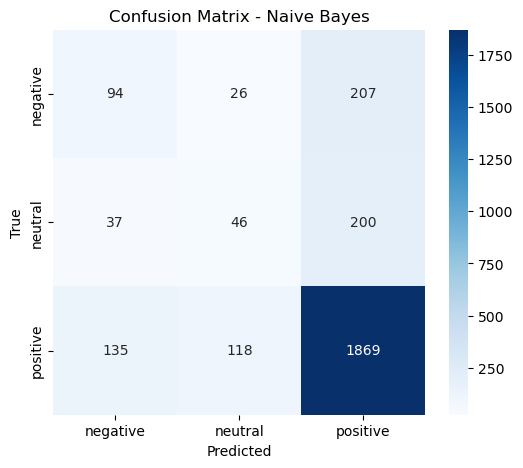

In [39]:
# 11. Confusion matrix for best model

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [46]:
# 12. Test best model on custom sample reviews

samples = [
    "گوشی خیلی خوب و با کیفیتیه، من کاملا راضیم.",
    "افتضاحه، داغ میکنه.",
    "معمولیه به نسبت قیمت"
]

clean_samples = [clean_text(s) for s in samples]
sample_tfidf = vectorizer.transform(clean_samples)
sample_pred = best_model.predict(sample_tfidf)
sample_labels = le.inverse_transform(sample_pred)

for s, lbl in zip(samples, sample_labels):
    print(f"{s} → {lbl}")


گوشی خیلی خوب و با کیفیتیه، من کاملا راضیم. → positive
افتضاحه، داغ میکنه. → negative
معمولیه به نسبت قیمت → neutral
